Попробуйте обучить нейронную сеть U-Net на любом другом датасете.

датасет https://www.kaggle.com/bulentsiyah/semantic-drone-dataset

In [1]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os, fnmatch
import gc

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, Average, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

In [2]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [3]:
def Color2index(y):
    arr_col = class_segment[class_segment.columns[1:]].values
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1

In [4]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x200

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x100

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x50

    # Block 4
    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1024, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    xblock_2_out = Conv2D(64, (3, 3), padding='same')(block_2_out)
    xblock_2_out = BatchNormalization()(xblock_2_out)
    xblock_2_out = Activation('relu')(xblock_2_out)
    xblock_2_out = Conv2D(128, (3, 3), padding='same')(xblock_2_out)
    xblock_2_out = BatchNormalization()(xblock_2_out)
    xblock_2_out = Activation('relu')(xblock_2_out)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out, xblock_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    xblock_1_out = Conv2D(64, (3, 3), padding='same')(block_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('tanh')(xblock_1_out)
    xblock_1_out = Conv2D(64, (3, 3), padding='same')(xblock_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('tanh')(xblock_1_out)
    xblock_1_out = Conv2D(64, (3, 3), padding='same')(xblock_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('relu')(xblock_1_out)
    xblock_1_out = Conv2D(64, (3, 3), padding='same')(xblock_1_out)
    xblock_1_out = BatchNormalization()(xblock_1_out)
    xblock_1_out = Activation('relu')(xblock_1_out)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out, xblock_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [5]:
class_segment = pd.read_csv('class_dict_seg.csv')
class_segment

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [6]:
class_segment[class_segment.columns[1:]].values

array([[  0,   0,   0],
       [128,  64, 128],
       [130,  76,   0],
       [  0, 102,   0],
       [112, 103,  87],
       [ 28,  42, 168],
       [ 48,  41,  30],
       [  0,  50,  89],
       [107, 142,  35],
       [ 70,  70,  70],
       [102, 102, 156],
       [254, 228,  12],
       [254, 148,  12],
       [190, 153, 153],
       [153, 153, 153],
       [255,  22,  96],
       [102,  51,   0],
       [  9, 143, 150],
       [119,  11,  32],
       [ 51,  51,   0],
       [190, 250, 190],
       [112, 150, 146],
       [  2, 135, 115],
       [255,   0,   0]], dtype=int64)

In [7]:
PAHT_label = r'C:\Users\EssenceD\Documents\Jupyter lab docs\nnets_intro\6\RGB_color_image_masks\RGB_color_image_masks\\'

PAHT_image = r'C:\Users\EssenceD\Documents\Jupyter lab docs\nnets_intro\6\dataset\semantic_drone_dataset\original_images\\'

In [8]:
imag = os.listdir(PAHT_image)
imag_label = os.listdir(PAHT_label)

In [9]:
len(imag), len(imag_label)

(400, 400)

In [10]:
h1 = 200
w1 = 400

In [11]:
images = []
segments = []
image_size = (h1,w1)
for i_name in imag[:150]:
    images.append(image.load_img(PAHT_image + i_name ,target_size=image_size))
    segments.append(image.load_img(PAHT_label + i_name.split('.')[0] + '.png', target_size=image_size))

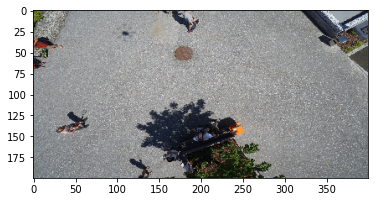

In [12]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

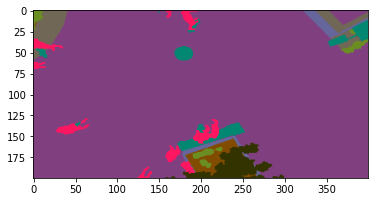

In [13]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [14]:
xTrain_Test = []

for img in images:
    x = image.img_to_array(img)
    xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)
xTrain_Test.shape

(150, 200, 400, 3)

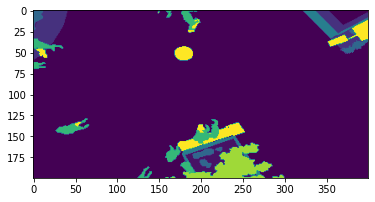

In [15]:
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float) / h)
plt.show()  

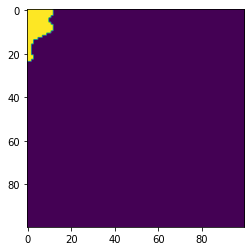

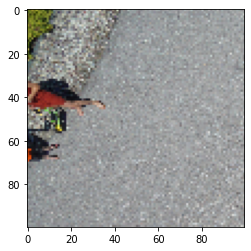

In [16]:
plt.imshow(cat_yi[:100,:100,8])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [17]:
yTrain_Test = []

for seg in segments:
    y_cat,_,_ = Color2index(image.img_to_array(seg))
    yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)
yTrain_Test.shape

(150, 200, 400, 24)

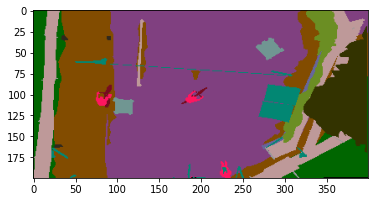

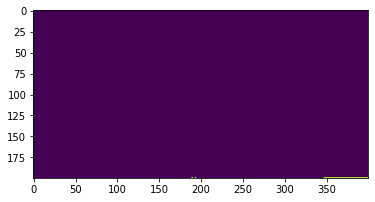

In [18]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

In [19]:
N = int(yTrain_Test.shape[0] - yTrain_Test.shape[0] * 0.2)
yTrain = yTrain_Test[:N, :, :, :]
xTrain = xTrain_Test[:N, :, :, :]

yTest = yTrain_Test[N:, :, :, :]
xTest = xTrain_Test[N:, :, :, :]

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\EssenceD\Documents\Jupyter lab docs\nnets_intro\6\modelUnet.mdw',
    monitor="val_dice_coef",
    save_best_only=True,
    save_weights_only=True,
)

In [21]:
modelC = Unet(class_segment[class_segment.columns[1:]].values.shape[0], (h1, w1, 3))

plot_model(modelC, to_file='modelC.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 400, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 400, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [22]:
xtr = xTrain[:100]
ytr = yTrain[:100]
xval = xTrain[100:]
yval = yTrain[100:]

In [23]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [24]:
best = 0
for i in range(10):
    print(best)
    history = modelC.fit(xtr, ytr, epochs=1, batch_size=1, validation_data=(xval, yval), callbacks=[model_checkpoint_callback])
    val = history.history['val_dice_coef'][0]
    if val > best:
        best = val
    gc.collect()

0
100/100 [==============================] - 31s 166ms/step - loss: 1.9899 - dice_coef: 0.2811 - val_loss: 61.2551 - val_dice_coef: 0.0094
0.009374568238854408
100/100 [==============================] - 13s 134ms/step - loss: 1.6591 - dice_coef: 0.3573 - val_loss: 8.7836 - val_dice_coef: 0.0662
0.06623176485300064
100/100 [==============================] - 13s 127ms/step - loss: 1.5521 - dice_coef: 0.3833 - val_loss: 4.9601 - val_dice_coef: 0.0971
0.09708411246538162
100/100 [==============================] - 13s 130ms/step - loss: 1.4833 - dice_coef: 0.4123 - val_loss: 4.8376 - val_dice_coef: 0.1250
0.12499687820672989
100/100 [==============================] - 13s 131ms/step - loss: 1.5071 - dice_coef: 0.4024 - val_loss: 7.5088 - val_dice_coef: 0.0747
0.12499687820672989
100/100 [==============================] - 30s 303ms/step - loss: 1.3979 - dice_coef: 0.4386 - val_loss: 3.2387 - val_dice_coef: 0.1434
0.14341479539871216
100/100 [==============================] - 14s 141ms/step - 

In [25]:
history = modelC.fit(xtr, ytr, epochs=1, batch_size=1, validation_data=(xval, yval), callbacks=[model_checkpoint_callback])
gc.collect()

100/100 [==============================] - 30s 294ms/step - loss: 1.1173 - dice_coef: 0.5384 - val_loss: 1.7565 - val_dice_coef: 0.4309


3912

In [26]:
modelC.save_weights(r'C:\Users\EssenceD\Documents\Jupyter lab docs\nnets_intro\6\modelUnet_best.mdw')

In [27]:
modelC = None
gc.collect()
modelC = Unet(class_segment[class_segment.columns[1:]].values.shape[0], (h1, w1, 3))
modelC.load_weights(r'C:\Users\EssenceD\Documents\Jupyter lab docs\nnets_intro\6\modelUnet_best.mdw')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 400, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 200, 400, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [28]:
pred = modelC.predict(xTest[:11], batch_size=1)
print(pred.shape)

(11, 200, 400, 24)


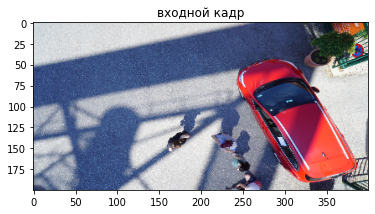

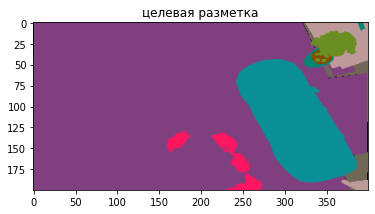

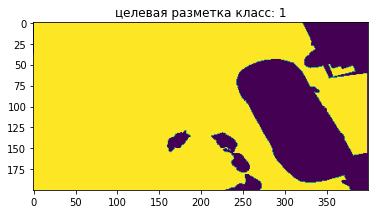

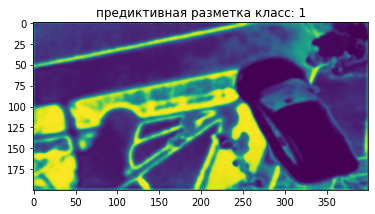

In [29]:
n = 1
class_ = 1#1#8#15
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()